source: https://sofifa.com/

# Importy

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import re
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import datasets, linear_model
import statsmodels.api as sm

# Wczytywanie danych i pre-processing

## Czyszczenie danych

In [42]:
df_org = pd.read_csv('Fifa2022-Males.csv', low_memory=False)
df = df_org.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 104 entries, sofifa_id to gk
dtypes: float64(18), int64(44), object(42)
memory usage: 15.3+ MB


In [43]:
df.columns.tolist()

['sofifa_id',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'moveme

In [44]:
main_position = []

position_info = {
    "RF":"Forward",
    "CF":"Forward",
    "LF":"Forward",
    "RS":"Forward",
    "ST":"Forward",
    "LS":"Forward",
    "LW":"Forward",
    "RW":"Forward",
    "RDM":"Middle",
    "RCDM":"Middle",
    "CDM":"Middle",
    "LCDM":"Middle",
    "LDM":"Middle",
    "RWM":"Middle",
    "RM":"Middle",
    "RCM":"Middle",
    "CM":"Middle",
    "LCM":"Middle",
    "LM":"Middle",
    "LWM":"Middle",
    "RAM":"Middle",
    "RCAM":"Middle",
    "CAM":"Middle",
    "LCAM":"Middle",
    "LAM":"Middle",
    "SW":"Back",
    "RWB":"Back",
    "RB":"Back",
    "RCB":"Back",
    "CB":"Back",
    "LCB":"Back",
    "LB":"Back",
    "LWB":"Back",
    "GK":"Goalkeeper"
}

for i in range(len(df)):
    if(df['club_position'][i] in position_info):
        main_position.append(position_info.get(df['club_position'][i]))
    elif (df['nation_position'][i] in position_info):
        main_position.append(position_info.get(df['nation_position'][i]))
    else:
        position_list = df['player_positions'][i].replace(" ", "").split(",")
        temp = []
        for j in range(len(position_list)):
            temp.append(position_info.get(position_list[j]))
        main_position.append(max(set(temp), key = temp.count))
df['player_position'] = main_position
df['player_position'].unique()

array(['Forward', 'Middle', 'Goalkeeper', 'Back'], dtype=object)

In [45]:
df = df.drop(columns=[
    'sofifa_id',
    'long_name',
    'dob',  # date of birth
    'club_team_id',
    'club_position',
    'club_jersey_number',
    'club_loaned_from',
    'club_joined',
    'club_contract_valid_until',
    'nationality_id',
    'nation_team_id',
    'nation_position',
    'nation_jersey_number',
    'work_rate',
    'body_type',
    'real_face',
    'player_tags',
    'player_traits',
    'preferred_foot',
]);

In [46]:
def nan_columns(df: DataFrame, head: int = 10):  # columns with quantities of NA descending
    print(df.isna().sum().sort_values(ascending=False).head(head))

In [47]:
nan_columns(df, head=18)

goalkeeping_speed     17107
passing                2132
shooting               2132
pace                   2132
defending              2132
physic                 2132
dribbling              2132
release_clause_eur     1176
rw                      326
lw                      326
value_eur                74
league_name              61
league_level             61
club_name                61
wage_eur                 61
rs                        0
lf                        0
cf                        0
dtype: int64


In [48]:
df = df.dropna(subset=['value_eur'])  # no data about value
df = df.drop(columns=['pace', 'defending', 'dribbling', 'passing', 'shooting', 'physic',
                      'goalkeeping_speed'])  # incompatible data (from 2 different versions, complementary nan's)])  
df['release_clause_eur'] = df['release_clause_eur'].fillna(0)  # probably no release clause
df['lw'] = df['lw'].fillna(df['lf'])  # position lw is closest to lf
df['rw'] = df['rw'].fillna(df['rf'])  # position rw is closest to rf

In [49]:
nan_columns(df, head=3)

short_name              0
goalkeeping_reflexes    0
rf                      0
dtype: int64


In [50]:
df = df.drop(columns=[ # usunięcie kolumn które znaczoąco wpływają na ocenę klasyfikatora
    'wage_eur',
    'release_clause_eur',
    'overall',
    'potential',
]);

In [51]:
cols_dict = {
    'descriptive': ['short_name',
                    'player_positions',
                    'player_position',  # przetworzone pozycje (1 z 4)
                    'club_name',
                    'league_name',
                    'nationality_name',
                    ],
   #'score': ['overall',
   #          'potential'],
    'attacking': ['attacking_crossing',
                  'attacking_finishing',
                  'attacking_heading_accuracy',
                  'attacking_short_passing',
                  'attacking_volleys'],
    'skill': ['skill_dribbling',
              'skill_curve',
              'skill_fk_accuracy',
              'skill_long_passing',
              'skill_ball_control'],
    'movement': ['movement_acceleration',
                 'movement_sprint_speed',
                 'movement_agility',
                 'movement_reactions',
                 'movement_balance'],
    'power': ['power_shot_power',
              'power_jumping',
              'power_stamina',
              'power_strength',
              'power_long_shots'],
    'mentality': ['mentality_aggression',
                  'mentality_interceptions',
                  'mentality_positioning',
                  'mentality_vision',
                  'mentality_penalties',
                  'mentality_composure'],
    'defending': ['defending_marking_awareness',
                  'defending_standing_tackle',
                  'defending_sliding_tackle'],
    'goalkeeping': ['goalkeeping_diving',
                    'goalkeeping_handling',
                    'goalkeeping_kicking',
                    'goalkeeping_positioning',
                    'goalkeeping_reflexes'],
    'position': [      'ls' ,'st' ,'rs',
                 'lw' ,'lf' ,'cf' ,'rf', 'rw',
                       'lam','cam','ram',
                 'lm' ,'lcm','cm' ,'rcm', 'rm',  # arrangement of positions
                 'lwb','ldm','cdm','rdm','rwb',
                 'lb', 'lcb','cb' ,'rcb', 'rb',
                             'gk']
}
cols_dict['features'] = [cols_dict[feature] for feature in cols_dict.keys()]
cols_dict['features'] = sum(cols_dict['features'], [])  # flaten list of lists
cols_dict['all'] = df.columns.to_list()
columns = cols_dict['all']
cols_dict['others'] = list(set(cols_dict['all']) - set(cols_dict['features']))
cols_dict['others'].sort()
cols_dict['others']

['age',
 'height_cm',
 'international_reputation',
 'league_level',
 'skill_moves',
 'value_eur',
 'weak_foot',
 'weight_kg']

In [52]:
df[cols_dict['position']] = df[cols_dict['position']].applymap(
    lambda datum: sum([int(x) for x in re.split(r'[+-]', datum)]) if isinstance(datum, str) 
    else int(datum))  # including +- for 'international_reputation'

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19165 entries, 0 to 19238
Data columns (total 75 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   short_name                   19165 non-null  object 
 1   player_positions             19165 non-null  object 
 2   value_eur                    19165 non-null  float64
 3   age                          19165 non-null  int64  
 4   height_cm                    19165 non-null  int64  
 5   weight_kg                    19165 non-null  int64  
 6   club_name                    19165 non-null  object 
 7   league_name                  19165 non-null  object 
 8   league_level                 19165 non-null  float64
 9   nationality_name             19165 non-null  object 
 10  weak_foot                    19165 non-null  int64  
 11  skill_moves                  19165 non-null  int64  
 12  international_reputation     19165 non-null  int64  
 13  attacking_crossing   

## Wizualizacja wyczyszczonych danych

In [54]:
df[cols_dict['descriptive']].describe()[1:]

short_name player_positions player_position            club_name  \
unique         18076              674               4                  701   
top     J. Rodríguez               CB          Middle  Paris Saint-Germain   
freq              13             2408            7133                   33   

                    league_name nationality_name  
unique                       55              163  
top     USA Major League Soccer          England  
freq                        771             1717

In [55]:
df[cols_dict['others']].describe()[1:]

age   height_cm  international_reputation  league_level  \
mean  25.190034  181.290008                  1.093817      1.354239   
std    4.727515    6.862654                  0.370406      0.747572   
min   16.000000  155.000000                  1.000000      1.000000   
25%   21.000000  176.000000                  1.000000      1.000000   
50%   25.000000  181.000000                  1.000000      1.000000   
75%   29.000000  186.000000                  1.000000      1.000000   
max   43.000000  206.000000                  5.000000      5.000000   

      skill_moves     value_eur  weak_foot   weight_kg  
mean     2.351944  2.850452e+06   2.945682   74.930342  
std      0.767516  7.613700e+06   0.671623    7.066639  
min      1.000000  9.000000e+03   1.000000   49.000000  
25%      2.000000  4.750000e+05   3.000000   70.000000  
50%      2.000000  9.750000e+05   3.000000   75.000000  
75%      3.000000  2.000000e+06   3.000000   80.000000  
max      5.000000  1.940000e+08   5.000000  110.000000

In [56]:
def show_boxplot(df: DataFrame, columns: str):
    if columns in cols_dict.keys():
        labels = cols_dict[columns]
        labels = [label.removeprefix(columns + '_') for label in labels]
    else:
        labels = None
    
    leftmargin = 0.5
    rightmargin = 0.3
    categorysize = 0.1

    n = df.shape[1]

    figwidth = leftmargin + rightmargin + (n+1)*categorysize

    fig, ax = plt.subplots(figsize=(figwidth, 6))
    fig.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth,
                        top=0.94, bottom=0.1)
    ax.boxplot(df[cols_dict[columns]], labels=labels)
    plt.title(columns)
    plt.show()

dict_keys(['descriptive', 'attacking', 'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping', 'position', 'features', 'all', 'others'])


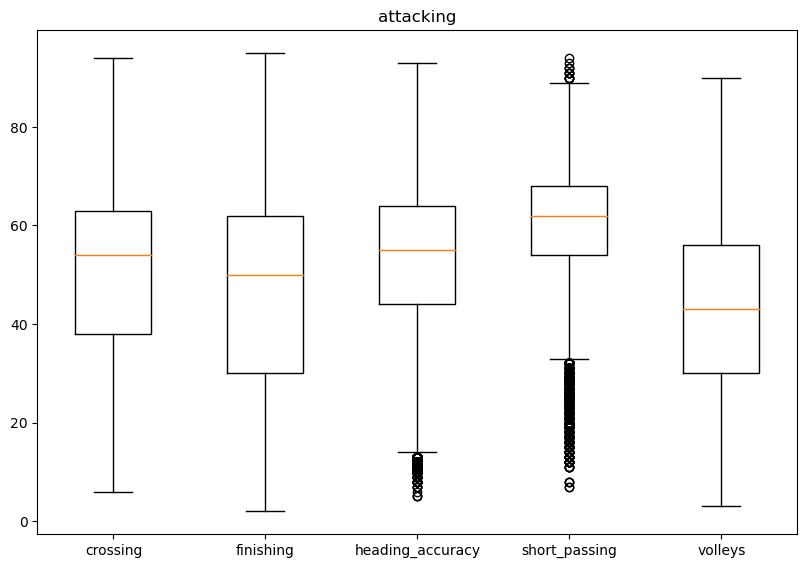

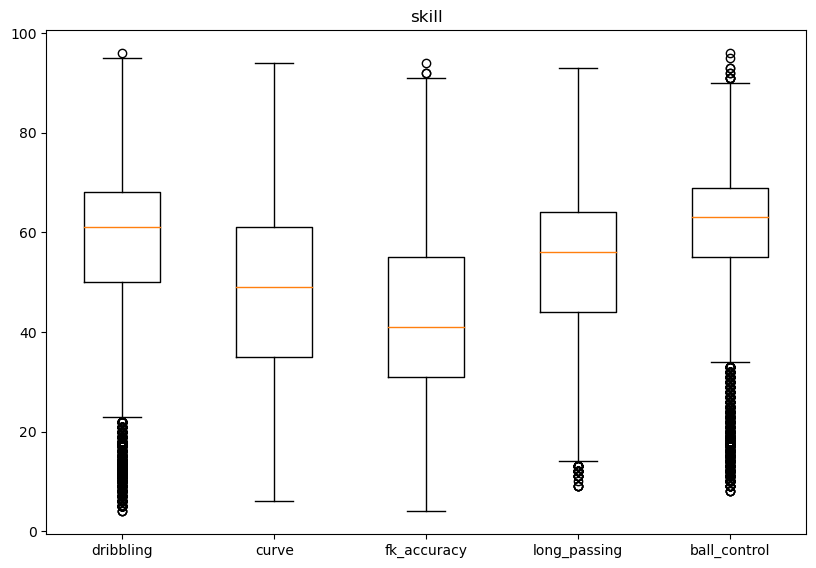

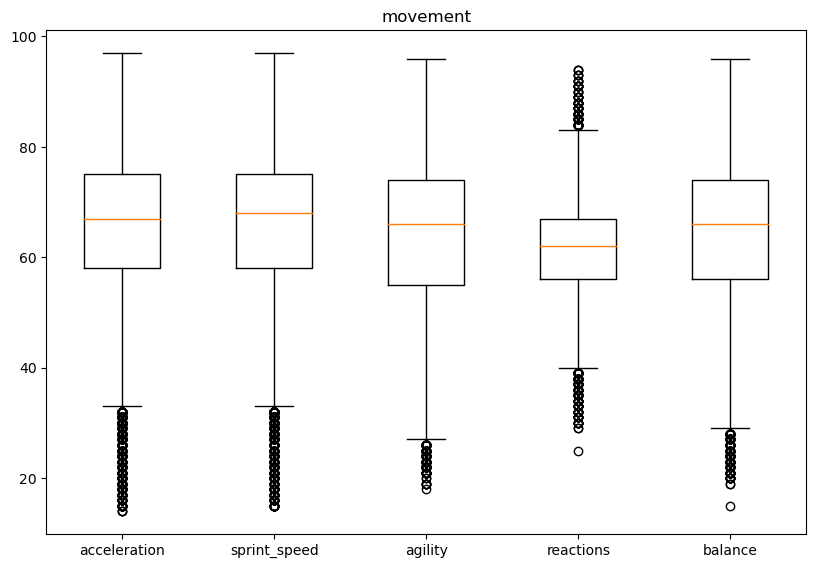

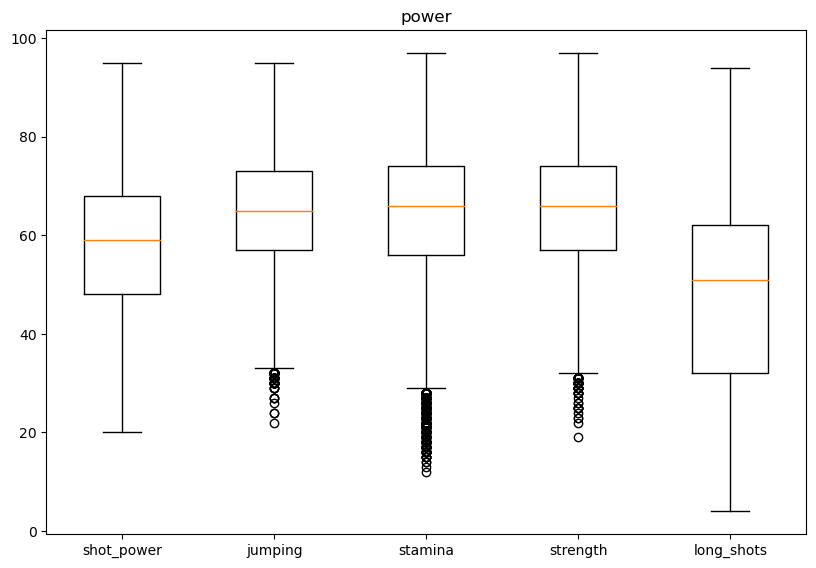

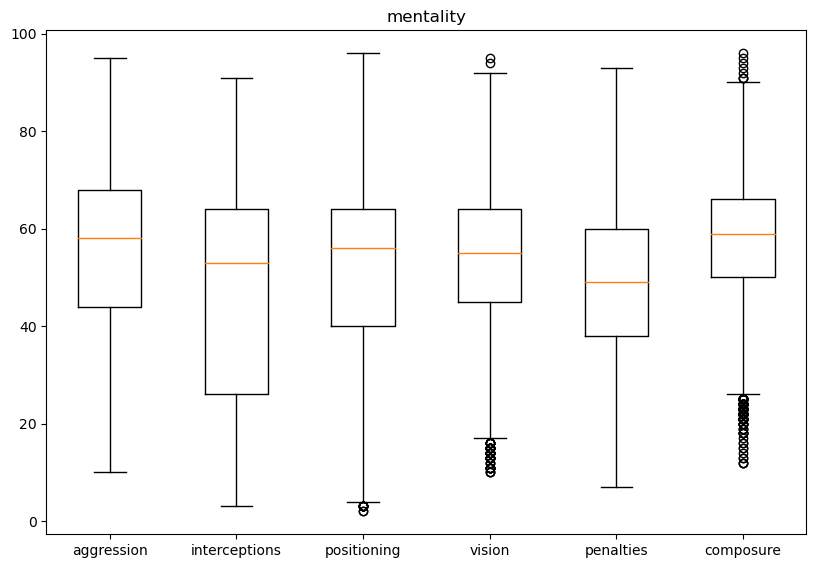

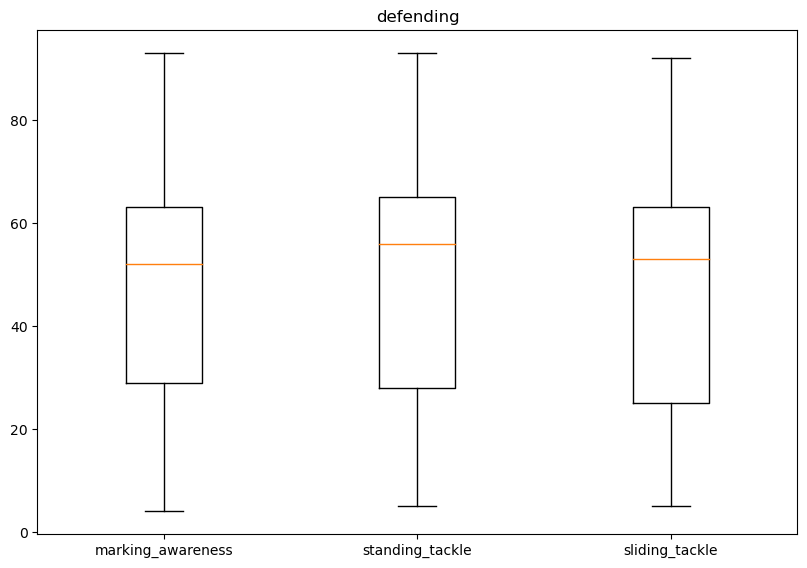

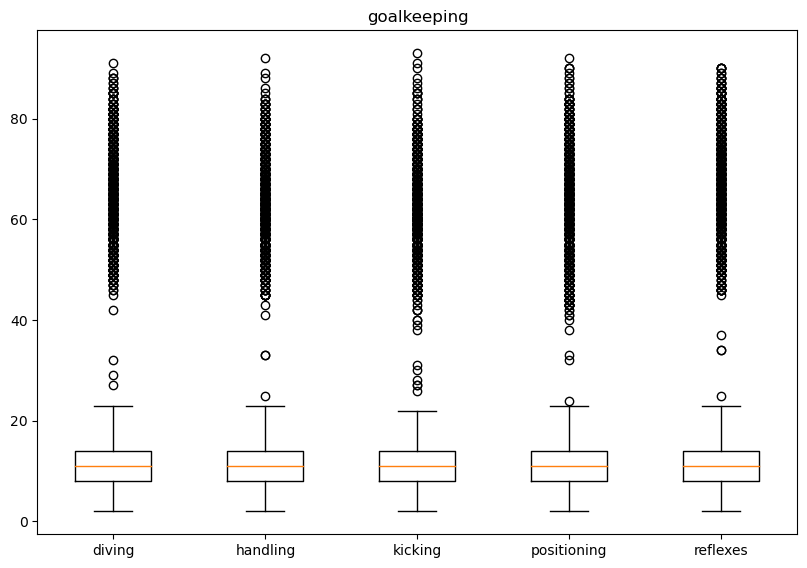

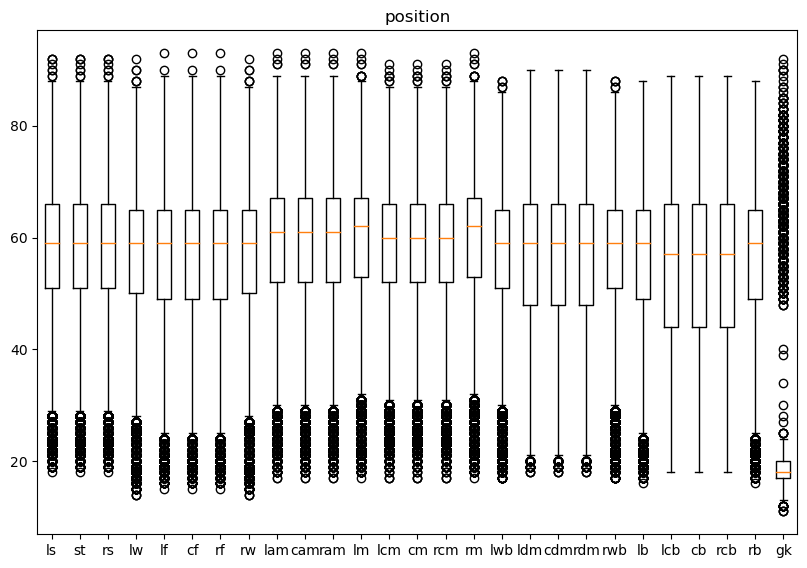

In [57]:
print(cols_dict.keys())
for key in cols_dict.keys():
    if key not in ['descriptive', 'features', 'all', 'others']:
        show_boxplot(df, key)

# Standaryzacja

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
df_stand = df.copy()

df_stand =  df_stand.drop(columns = cols_dict['descriptive'])

df_stand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19165 entries, 0 to 19238
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   value_eur                    19165 non-null  float64
 1   age                          19165 non-null  int64  
 2   height_cm                    19165 non-null  int64  
 3   weight_kg                    19165 non-null  int64  
 4   league_level                 19165 non-null  float64
 5   weak_foot                    19165 non-null  int64  
 6   skill_moves                  19165 non-null  int64  
 7   international_reputation     19165 non-null  int64  
 8   attacking_crossing           19165 non-null  int64  
 9   attacking_finishing          19165 non-null  int64  
 10  attacking_heading_accuracy   19165 non-null  int64  
 11  attacking_short_passing      19165 non-null  int64  
 12  attacking_volleys            19165 non-null  int64  
 13  skill_dribbling      

In [60]:
scaler = StandardScaler()
data_1 = df_stand.iloc[:,:]
data_stand = scaler.fit_transform(data_1)
data_stand

array([[ 9.87056351,  1.86359972, -1.64518018, ..., -0.09175446,
         0.60450243, -0.08375154],
       [15.32140647,  1.44053345,  0.54062014, ...,  0.58798046,
         0.60450243, -0.08375154],
       [ 5.53615826,  2.28666598,  0.83206018, ...,  0.11216602,
         0.53345973, -0.01738129],
       ...,
       [-0.36125978, -0.886331  , -0.47942001, ..., -0.49959541,
        -0.46113814, -0.61471362],
       [-0.35994632, -1.30939726, -1.20802011, ..., -1.79109176,
        -1.52677872, -0.41560284],
       [-0.35994632, -1.30939726, -2.08234024, ..., -0.77148938,
        -0.60322355, -0.34923258]])

# Wyznaczanie składowych głównych

In [61]:
from sklearn.decomposition import PCA

In [62]:
index_pca = [
 #'overall',
 #'potential',
 'value_eur',
 #'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'league_level',
 'weak_foot',
 'skill_moves',
 'international_reputation', 
 #'release_clause_eur',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',  
 'goalkeeping_diving',
 'goalkeeping_handling', 
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'ls',
 'st',
 'rs',
 'lw',
 'lf',
 'cf',
 'rf',
 'rw',
 'lam',
 'cam',
 'ram',
 'lm',
 'lcm',
 'cm',
 'rcm', 
 'rm',
 'lwb',
 'ldm',
 'cdm',
 'rdm' ,
 'rwb', 
 'lb',
 'lcb', 
 'cb',
 'rcb',
 'rb',
 'gk'
]

In [63]:
pca = PCA()
pca_data = pca.fit_transform(data_stand)
n_components = len(pca.components_)
pca_cols = [f'PC{x+1}' for x in range(n_components)]
df_pca_componenets = pd.DataFrame(data=np.transpose(pca.components_), columns=pca_cols, index = index_pca)
df_pca_componenets.abs().sort_values(by='PC1',ascending=False).iloc[:7,:]

PC1       PC2       PC3       PC4       PC5  \
lcm                 0.151049  0.001376  0.051643  0.044389  0.057360   
rcm                 0.151049  0.001376  0.051643  0.044389  0.057360   
cm                  0.151049  0.001376  0.051643  0.044389  0.057360   
lm                  0.149650  0.065638  0.004215  0.019791  0.020403   
rm                  0.149650  0.065638  0.004215  0.019791  0.020403   
skill_ball_control  0.147965  0.037445  0.001415  0.031102  0.012738   
ram                 0.147744  0.081691  0.032037  0.012072  0.014025   

                         PC6       PC7       PC8       PC9      PC10  \
lcm                 0.020187  0.019891  0.033589  0.026371  0.064200   
rcm                 0.020187  0.019891  0.033589  0.026371  0.064200   
cm                  0.020187  0.019891  0.033589  0.026371  0.064200   
lm                  0.002560  0.009764  0.065119  0.037795  0.022374   
rm                  0.002560  0.009764  0.065119  0.037795  0.022374   
skill_ball_control  0.049336  0.002366  0.016928  0.012672  0.022133   
ram                 0.012551  0.011507  0.049373  0.026894  0.038543   

                        PC11      PC12      PC13      PC14      PC15  \
lcm                 0.075301  0.086452  0.034477  0.033840  0.004428   
rcm                 0.075301  0.086452  0.034477  0.033840  0.004428   
cm                  0.075301  0.086452  0.034477  0.033840  0.004428   
lm                  0.044233  0.047756  0.033948  0.000674  0.057012   
rm                  0.044233  0.047756  0.033948  0.000674  0.057012   
skill_ball_control  0.126370  0.067247  0.049453  0.033726  0.002648   
ram                 0.071951  0.062980  0.037396  0.002841  0.005925   

                        PC16      PC17      PC18      PC19      PC20  \
lcm                 0.008940  0.018255  0.022146  0.033752  0.013189   
rcm                 0.008940  0.018255  0.022146  0.033752  0.013189   
cm                  0.008940  0.018255  0.022146  0.033752  0.013189   
lm                  0.011735  0.027144  0.018073  0.034414  0.033383   
rm                  0.011735  0.027144  0.018073  0.034414  0.033383   
skill_ball_control  0.041176  0.038468  0.055359  0.014161  0.050306   
ram                 0.005462  0.021078  0.020321  0.008091  0.004755   

                        PC21      PC22      PC23      PC24      PC25  \
lcm                 0.048423  0.007703  0.003749  0.000124  0.002941   
rcm                 0.048423  0.007703  0.003749  0.000124  0.002941   
cm                  0.048423  0.007703  0.003749  0.000124  0.002941   
lm                  0.005980  0.044822  0.045451  0.031068  0.005926   
rm                  0.005980  0.044822  0.045451  0.031068  0.005926   
skill_ball_control  0.012542  0.097767  0.019443  0.077812  0.035681   
ram                 0.008712  0.037515  0.017517  0.004962  0.008541   

                        PC26      PC27      PC28      PC29      PC30  \
lcm                 0.013661  0.003568  0.006204  0.019302  0.016392   
rcm                 0.013661  0.003568  0.006204  0.019302  0.016392   
cm                  0.013661  0.003568  0.006204  0.019302  0.016392   
lm                  0.003283  0.028354  0.009577  0.002743  0.046654   
rm                  0.003283  0.028354  0.009577  0.002743  0.046654   
skill_ball_control  0.037747  0.145890  0.000047  0.195322  0.359676   
ram                 0.018810  0.037275  0.001582  0.040602  0.044909   

                        PC31      PC32      PC33      PC34      PC35  \
lcm                 0.013248  0.029647  0.007822  0.046734  0.011271   
rcm                 0.013248  0.029647  0.007822  0.046734  0.011271   
cm                  0.013248  0.029647  0.007822  0.046734  0.011271   
lm                  0.004629  0.006859  0.010042  0.008406  0.030931   
rm                  0.004629  0.006859  0.010042  0.008406  0.030931   
skill_ball_control  0.194108  0.032626  0.050538  0.025475  0.002176   
ram                 0.029985  0.001158  0.002842  0.005917 

In [64]:
df_pca_componenets.abs().sort_values(by='PC2',ascending=False).iloc[:7,:]

PC1       PC2       PC3       PC4       PC5  \
defending_sliding_tackle     0.084976  0.258602  0.053252  0.102452  0.050891   
defending_standing_tackle    0.090044  0.253757  0.041743  0.094096  0.060666   
mentality_interceptions      0.089632  0.251947  0.003086  0.106957  0.054085   
defending_marking_awareness  0.093212  0.245470  0.017209  0.081792  0.042106   
lcb                          0.111830  0.225956  0.015717  0.007569  0.005476   
rcb                          0.111830  0.225956  0.015717  0.007569  0.005476   
cb                           0.111830  0.225956  0.015717  0.007569  0.005476   

                                  PC6       PC7       PC8       PC9      PC10  \
defending_sliding_tackle     0.025947  0.021764  0.000116  0.008514  0.005378   
defending_standing_tackle    0.031994  0.027463  0.001711  0.009659  0.000165   
mentality_interceptions      0.011860  0.013533  0.010271  0.000385  0.014725   
defending_marking_awareness  0.000940  0.018638  0.020385  0.000318  0.028834   
lcb                          0.007622  0.002198  0.006312  0.003111  0.016409   
rcb                          0.007622  0.002198  0.006312  0.003111  0.016409   
cb                           0.007622  0.002198  0.006312  0.003111  0.016409   

                                 PC11      PC12      PC13      PC14      PC15  \
defending_sliding_tackle     0.093298  0.049754  0.015571  0.092369  0.029709   
defending_standing_tackle    0.083890  0.054703  0.002824  0.071968  0.017840   
mentality_interceptions      0.059737  0.059010  0.001975  0.052228  0.025842   
defending_marking_awareness  0.037877  0.052643  0.023111  0.050806  0.019980   
lcb                          0.035192  0.058795  0.005297  0.044388  0.018799   
rcb                          0.035192  0.058795  0.005297  0.044388  0.018799   
cb                           0.035192  0.058795  0.005297  0.044388  0.018799   

                                 PC16      PC17      PC18      PC19      PC20  \
defending_sliding_tackle     0.007682  0.070038  0.050692  0.056332  0.049256   
defending_standing_tackle    0.023051  0.062868  0.014540  0.064947  0.052214   
mentality_interceptions      0.042177  0.050967  0.038355  0.049021  0.068272   
defending_marking_awareness  0.017121  0.021247  0.012399  0.070658  0.079841   
lcb                          0.019421  0.030723  0.020187  0.006455  0.022708   
rcb                          0.019421  0.030723  0.020187  0.006455  0.022708   
cb                           0.019421  0.030723  0.020187  0.006455  0.022708   

                                 PC21      PC22      PC23      PC24      PC25  \
defending_sliding_tackle     0.101442  0.086924  0.019002  0.006594  0.027198   
defending_standing_tackle    0.095766  0.109838  0.003713  0.005336  0.035493   
mentality_interceptions      0.070759  0.137644  0.061033  0.032987  0.022309   
defending_marking_awareness  0.116059  0.080268  0.043937  0.036924  0.026706   
lcb                          0.040777  0.078586  0.019447  0.012443  0.006232   
rcb                          0.040777  0.078586  0.019447  0.012443  0.006232   
cb                           0.040777  0.078586  0.019447  0.012443  0.006232   

                                 PC26      PC27      PC28      PC29      PC30  \
defending_sliding_tackle     0.008081  0.019160  0.013194  0.000951  0.004911   
defending_standing_tackle    0.052343  0.021017  0.003469  0.001892  0.000018   
mentality_interceptions      0.063523  0.018097  0.052620  0.012075  0.060182   
defending_marking_awareness  0.035115  0.013362  0.055397  0.085439  0.019493   
lcb                          0.006288  0.003405  0.043724  0.019342  0.004838   
rcb                          0.006288  0.003405  0.043724  0.019342  0.004838   
cb                           0.006288  0.003405  0.043724  0.019342  0.004838   

                                 PC31      PC32      PC33      PC34      PC35  \
defending_sliding_tackle     0.181541  0.354712  0.072732  

In [65]:
df_pca_componenets.abs().sort_values(by='PC3',ascending=False).iloc[:7,:]

PC1       PC2       PC3       PC4       PC5  \
movement_reactions        0.076632  0.020014  0.328813  0.116093  0.124714   
age                       0.020756  0.038243  0.279940  0.016591  0.149668   
weight_kg                 0.050361  0.096877  0.264321  0.315226  0.014973   
international_reputation  0.033504  0.005070  0.245581  0.124096  0.295372   
power_strength            0.027795  0.150321  0.234130  0.350121  0.104943   
gk                        0.123428  0.032175  0.228487  0.187685  0.018691   
power_shot_power          0.092856  0.134756  0.224822  0.050833  0.113948   

                               PC6       PC7       PC8       PC9      PC10  \
movement_reactions        0.082998  0.045822  0.080644  0.018316  0.056926   
age                       0.423543  0.147634  0.234425  0.289374  0.546265   
weight_kg                 0.033282  0.066380  0.166025  0.155118  0.219241   
international_reputation  0.404311  0.092136  0.298468  0.342932  0.241682   
power_strength            0.110561  0.015736  0.097568  0.094898  0.098101   
gk                        0.089565  0.016701  0.094755  0.069733  0.039808   
power_shot_power          0.051238  0.008135  0.020447  0.023626  0.167565   

                              PC11      PC12      PC13      PC14      PC15  \
movement_reactions        0.312904  0.276796  0.318144  0.154359  0.114957   
age                       0.228207  0.021803  0.094054  0.148274  0.146222   
weight_kg                 0.167475  0.247491  0.000337  0.056344  0.152312   
international_reputation  0.031273  0.247314  0.283189  0.345265  0.162843   
power_strength            0.071724  0.004825  0.119701  0.328581  0.235500   
gk                        0.031607  0.053784  0.006426  0.060772  0.023401   
power_shot_power          0.313093  0.269642  0.178501  0.161020  0.261504   

                              PC16      PC17      PC18      PC19      PC20  \
movement_reactions        0.017969  0.188774  0.232546  0.081345  0.163496   
age                       0.070447  0.109516  0.232823  0.142650  0.170265   
weight_kg                 0.317233  0.553576  0.103329  0.048458  0.221782   
international_reputation  0.180007  0.036122  0.238545  0.020726  0.110817   
power_strength            0.021756  0.087629  0.033746  0.030567  0.596671   
gk                        0.044721  0.032937  0.018793  0.002287  0.060755   
power_shot_power          0.027205  0.096940  0.233944  0.351591  0.126551   

                              PC21      PC22      PC23      PC24      PC25  \
movement_reactions        0.279347  0.130168  0.290641  0.240833  0.117803   
age                       0.074015  0.080788  0.038667  0.002447  0.082199   
weight_kg                 0.133822  0.041367  0.180653  0.204915  0.155643   
international_reputation  0.008174  0.065765  0.012112  0.034450  0.011694   
power_strength            0.324215  0.084355  0.186715  0.085162  0.038933   
gk                        0.002644  0.030500  0.051694  0.099234  0.032903   
power_shot_power          0.041061  0.296567  0.008447  0.096347  0.077271   

                              PC26      PC27      PC28      PC29      PC30  \
movement_reactions        0.161990  0.111756  0.237331  0.085368  0.111014   
age                       0.026176  0.030506  0.017737  0.070375  0.042362   
weight_kg                 0.010131  0.036929  0.089605  0.011144  0.007653   
international_reputation  0.002462  0.022999  0.011274  0.002899  0.018826   
power_strength            0.004610  0.022248  0.137001  0.016740  0.014273   
gk                        0.069445  0.012004  0.101417  0.019937  0.008228   
power_shot_power          0.390690  0.065183  0.116562  0.031339  0.146431   

                              PC31      PC32      PC33      PC34      PC35  \
movement_reactions        0.053070  0.036514  0.018283  0.053284  0.064817   
age                       0.006522  0.051608  0.001050  0.016600  0.021767   
weight_kg                 0.004453  0.004702  0

In [66]:
df_pca_componenets.abs().sort_values(by='PC4',ascending=False).iloc[:7,:]

PC1       PC2       PC3       PC4       PC5  \
power_strength              0.027795  0.150321  0.234130  0.350121  0.104943   
height_cm                   0.063633  0.108365  0.218849  0.323436  0.007295   
weight_kg                   0.050361  0.096877  0.264321  0.315226  0.014973   
attacking_heading_accuracy  0.112179  0.099312  0.022750  0.297895  0.100684   
movement_balance            0.097691  0.100550  0.167483  0.242378  0.121694   
gk                          0.123428  0.032175  0.228487  0.187685  0.018691   
goalkeeping_handling        0.126904  0.032976  0.202086  0.177535  0.006720   

                                 PC6       PC7       PC8       PC9      PC10  \
power_strength              0.110561  0.015736  0.097568  0.094898  0.098101   
height_cm                   0.141567  0.147440  0.191184  0.188166  0.056259   
weight_kg                   0.033282  0.066380  0.166025  0.155118  0.219241   
attacking_heading_accuracy  0.016027  0.091243  0.101447  0.088842  0.087898   
movement_balance            0.151105  0.020434  0.108256  0.109498  0.039724   
gk                          0.089565  0.016701  0.094755  0.069733  0.039808   
goalkeeping_handling        0.087400  0.020438  0.089771  0.067521  0.035612   

                                PC11      PC12      PC13      PC14      PC15  \
power_strength              0.071724  0.004825  0.119701  0.328581  0.235500   
height_cm                   0.087550  0.166831  0.112746  0.177458  0.181444   
weight_kg                   0.167475  0.247491  0.000337  0.056344  0.152312   
attacking_heading_accuracy  0.138592  0.125981  0.081311  0.140316  0.086007   
movement_balance            0.025086  0.017515  0.008313  0.114188  0.345405   
gk                          0.031607  0.053784  0.006426  0.060772  0.023401   
goalkeeping_handling        0.050103  0.031890  0.024822  0.046862  0.016932   

                                PC16      PC17      PC18      PC19      PC20  \
power_strength              0.021756  0.087629  0.033746  0.030567  0.596671   
height_cm                   0.081801  0.260782  0.048386  0.047989  0.356513   
weight_kg                   0.317233  0.553576  0.103329  0.048458  0.221782   
attacking_heading_accuracy  0.064068  0.033437  0.078312  0.008450  0.079111   
movement_balance            0.271982  0.326075  0.201518  0.067185  0.075083   
gk                          0.044721  0.032937  0.018793  0.002287  0.060755   
goalkeeping_handling        0.048110  0.014273  0.000979  0.003678  0.042865   

                                PC21      PC22      PC23      PC24      PC25  \
power_strength              0.324215  0.084355  0.186715  0.085162  0.038933   
height_cm                   0.080884  0.052305  0.258183  0.400508  0.353893   
weight_kg                   0.133822  0.041367  0.180653  0.204915  0.155643   
attacking_heading_accuracy  0.021822  0.024281  0.014841  0.110004  0.060081   
movement_balance            0.089770  0.008916  0.071186  0.344700  0.567140   
gk                          0.002644  0.030500  0.051694  0.099234  0.032903   
goalkeeping_handling        0.017237  0.035745  0.075869  0.111157  0.042541   

                                PC26      PC27      PC28      PC29      PC30  \
power_strength              0.004610  0.022248  0.137001  0.016740  0.014273   
height_cm                   0.008564  0.132624  0.114764  0.044842  0.007696   
weight_kg                   0.010131  0.036929  0.089605  0.011144  0.007653   
attacking_heading_accuracy  0.247714  0.119966  0.751779  0.012722  0.114310   
movement_balance            0.011293  0.074064  0.050750  0.039743  0.027813   
gk                          0.069445  0.012004  0.101417  0.019937  0.008228   
goalkeeping_handling        0.080389  0.013595  0.115663  0.022687  0.014450   

                                PC31      PC32      PC33      PC34      PC35  \
power_strength              0.003388  0.031291  0.008758  0.001236  0.024693   
height_cm                  

# Kryterium wartości własnej

In [67]:
print(pca_cols[:10])
print(pca.explained_variance_[:10])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
[42.33628323  9.07174188  4.3033168   2.50036375  1.34233797  1.20160446
  0.9715653   0.85647258  0.8115265   0.58752956]


# Kryterium częsci wyjaśnionej wariancji

In [68]:
print(pca_cols[:10])
print(np.cumsum(pca.explained_variance_ratio_)[:10])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
[0.61353731 0.74500497 0.80736862 0.84360389 0.86305705 0.88047069
 0.89455062 0.90696262 0.91872326 0.92723773]


# Kryterium minimalnego zasobu zmienności

In [69]:
pd.set_option('display.max_rows', None) # wyświetlanie wszyskich wierszów
pd.set_option('display.max_columns', None) # wyświetlanie wszyskich kolumn
pcaS = df_pca_componenets.pow(2).cumsum(axis=1)
pcaS

PC1       PC2       PC3       PC4       PC5  \
value_eur                    0.001858  0.001983  0.051841  0.074619  0.233170   
age                          0.000431  0.001893  0.080260  0.080535  0.102936   
height_cm                    0.004049  0.015792  0.063687  0.168298  0.168351   
weight_kg                    0.002536  0.011921  0.081787  0.181155  0.181379   
league_level                 0.000098  0.000103  0.005076  0.012391  0.013864   
weak_foot                    0.002802  0.007511  0.010966  0.010980  0.012238   
skill_moves                  0.013906  0.025360  0.025360  0.025599  0.025773   
international_reputation     0.001123  0.001148  0.061458  0.076858  0.164103   
attacking_crossing           0.018049  0.019650  0.020334  0.033038  0.036967   
attacking_finishing          0.014115  0.045332  0.046734  0.062422  0.063642   
attacking_heading_accuracy   0.012584  0.022447  0.022965  0.111706  0.121843   
attacking_short_passing      0.020924  0.021228  0.022864  0.023560  0.028705   
attacking_volleys            0.014512  0.036406  0.040284  0.052586  0.055236   
skill_dribbling              0.020548  0.027776  0.028983  0.029003  0.029013   
skill_curve                  0.016942  0.026219  0.027627  0.030741  0.046173   
skill_fk_accuracy            0.014496  0.020994  0.023450  0.027396  0.078774   
skill_long_passing           0.016940  0.019183  0.024053  0.040177  0.071534   
skill_ball_control           0.021894  0.023296  0.023298  0.024265  0.024427   
movement_acceleration        0.011871  0.021233  0.046726  0.051537  0.153468   
movement_sprint_speed        0.011460  0.017655  0.038509  0.038642  0.166423   
movement_agility             0.012458  0.027090  0.036547  0.062789  0.094563   
movement_reactions           0.005872  0.006273  0.114391  0.127869  0.143422   
movement_balance             0.009544  0.019654  0.047704  0.106451  0.121261   
power_shot_power             0.008622  0.026781  0.077326  0.079910  0.092894   
power_jumping                0.001870  0.011573  0.017059  0.026598  0.227079   
power_stamina                0.016122  0.020222  0.020735  0.021374  0.035134   
power_strength               0.000773  0.023369  0.078186  0.200771  0.211784   
power_long_shots             0.016561  0.032802  0.037404  0.040764  0.054943   
mentality_aggression         0.011290  0.039798  0.043014  0.048231  0.048542   
mentality_interceptions      0.008034  0.071511  0.071521  0.082960  0.085885   
mentality_positioning        0.017966  0.033588  0.033613  0.037406  0.037662   
mentality_vision             0.012057  0.025320  0.047754  0.070007  0.094945   
mentality_penalties          0.013858  0.029378  0.031299  0.053181  0.057974   
mentality_composure          0.013793  0.013822  0.055636  0.056407  0.056614   
defending_marking_awareness  0.008689  0.068944  0.069240  0.075930  0.077703   
defending_standing_tackle    0.008108  0.072500  0.074243  0.083097  0.086777   
defending_sliding_tackle     0.007221  0.074096  0.076932  0.087428  0.090018   
goalkeeping_diving           0.016168  0.017238  0.058021  0.089127  0.089202   
goalkeeping_handling         0.016105  0.017192  0.058031  0.089550  0.089595   
goalkeeping_kicking          0.015988  0.017113  0.058086  0.088900  0.088934   
goalkeeping_positioning      0.015953  0.017039  0.059075  0.090404  0.090492   
goalkeeping_reflexes         0.016104  0.017221  0.058443  0.089820  0.089928   
ls                           0.020876  0.028881  0.031377  0.040142  0.040778   
st                           0.020876  0.028881  0.031377  0.040142  0.040778   
rs                           0.020876  0.028881  0.031377  0.040142  0.040778   
lw                           0.021563  0.030164  0.030168  0.030196  0.030526   
lf                           0.021263  0.030828  0.031889  0.032474  0.032489   
cf                           0.021263  0.030828  0.031889  0.032474  0.032489   
rf                           0.021263  0.030828  0.031889  0.0324

# Analiza czynnikowa

In [70]:
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Wyliczenie współczynników FA

In [71]:
fa = FactorAnalysis(random_state=1)
data_transformed = fa.fit_transform(data_stand)
n_components = len(fa.components_)
fa_cols = [f'F{x+1}' for x in range(n_components)]
df_fa_componenets = pd.DataFrame(data=np.transpose(fa.components_), columns=fa_cols, index = index_pca)
df_fa_componenets

F1        F2        F3        F4        F5  \
value_eur                   -0.300893 -0.026287  0.222201  0.172044  0.263552   
age                         -0.150631  0.098557  0.196185  0.372845  0.260689   
height_cm                    0.390182  0.230029 -0.082915  0.531320  0.048131   
weight_kg                    0.303025  0.195668 -0.059296  0.566852  0.113744   
league_level                 0.072331  0.001166 -0.098195 -0.059260 -0.054626   
weak_foot                   -0.340234 -0.183860  0.053643  0.046720  0.013597   
skill_moves                 -0.757063 -0.296374 -0.014187 -0.091552 -0.012811   
international_reputation    -0.233283 -0.010440  0.213458  0.225505  0.201183   
attacking_crossing          -0.870331 -0.084142  0.031669 -0.292428  0.120988   
attacking_finishing         -0.774810 -0.550020 -0.131899  0.136407 -0.023621   
attacking_heading_accuracy  -0.715149  0.231307 -0.430342  0.319024 -0.117647   
attacking_short_passing     -0.949220  0.056545  0.134522  0.036977 -0.132480   
attacking_volleys           -0.778478 -0.448136 -0.101074  0.147963 -0.020410   
skill_dribbling             -0.932473 -0.254113 -0.051839 -0.131714 -0.037412   
skill_curve                 -0.842155 -0.256617  0.070423 -0.057842  0.028905   
skill_fk_accuracy           -0.775886 -0.200167  0.119289 -0.005049 -0.033541   
skill_long_passing          -0.859129  0.169474  0.336902  0.033485 -0.152040   
skill_ball_control          -0.964202 -0.118223 -0.034339 -0.020954 -0.087017   
movement_acceleration       -0.692756 -0.260519 -0.223489 -0.443554  0.180514   
movement_sprint_speed       -0.681291 -0.221754 -0.291339 -0.384847  0.203276   
movement_agility            -0.714835 -0.312253  0.012135 -0.365819  0.112463   
movement_reactions          -0.538622  0.049309  0.322469  0.393001  0.426050   
movement_balance            -0.613801 -0.225693  0.025693 -0.442422  0.009690   
power_shot_power            -0.623046 -0.410795  0.113429  0.405151  0.173462   
power_jumping               -0.271223  0.254908 -0.205517  0.220561  0.182007   
power_stamina               -0.818290  0.192209 -0.108397 -0.077926  0.049530   
power_strength              -0.193576  0.352113 -0.222861  0.628969  0.103407   
power_long_shots            -0.839946 -0.382584 -0.005720  0.141282 -0.021594   
mentality_aggression        -0.684910  0.483257 -0.121716  0.220385 -0.018698   
mentality_interceptions     -0.581477  0.781081  0.021717 -0.015100  0.025618   
mentality_positioning       -0.873696 -0.387844 -0.103635  0.005744 -0.001209   
mentality_vision            -0.742224 -0.322336  0.436320  0.080821  0.010172   
mentality_penalties         -0.755425 -0.382082 -0.145792  0.151987 -0.077250   
mentality_composure         -0.778754 -0.022894  0.175654  0.258862  0.134554   
defending_marking_awareness -0.601317  0.755935 -0.027498 -0.023989  0.000689   
defending_standing_tackle   -0.580249  0.786434 -0.027342 -0.062884 -0.018627   
defending_sliding_tackle    -0.545996  0.801495 -0.039944 -0.097041 -0.002785   
goalkeeping_diving           0.792019 -0.083071  0.410962  0.182333  0.373685   
goalkeeping_handling         0.790344 -0.083658  0.414024  0.181115  0.371471   
goalkeeping_kicking          0.787428 -0.085498  0.410624  0.184448  0.363139   
goalkeeping_positioning      0.786002 -0.084273  0.413652  0.186259  0.377246   
goalkeeping_reflexes         0.790096 -0.085472  0.411819  0.183408  0.376555   
ls                          -0.942738 -0.287041 -0.116465  0.115168  0.021017   
st                          -0.942738 -0.287041 -0.116465  0.115168  0.021017   
rs                          -0.942738 -0.287041 -0.116465  0.115168  0.021017   
lw                          -0.957396 -0.273654 -0.026742 -0.077976  0.023944   
lf                          -0.953746 -0.297746 -0.022973  0.016294  0.012238   
cf                          -0.953746 -0.297746 -0.022973  0.016294  0.012238   
rf                          -0.953746 -0.297746 -0.022973  0.01629

# Rotacja varimax

In [72]:
fav = FactorAnalysis(random_state=1, rotation = 'varimax')
data_transformed = fav.fit_transform(data_stand)
n_components = len(fav.components_)
fav_cols = [f'F{x+1}' for x in range(n_components)]
df_fav_componenets = pd.DataFrame(data=np.transpose(fav.components_), columns=fav_cols, index = index_pca)
df_fav_componenets

F1        F2        F3        F4        F5  \
value_eur                   -0.268310  0.138352  0.201718  0.069763  0.067396   
age                         -0.149040  0.165388  0.321355  0.207104  0.033502   
height_cm                    0.367605 -0.044847  0.107259  0.794289  0.023006   
weight_kg                    0.269860 -0.027308  0.152466  0.797250  0.000791   
league_level                 0.067928 -0.043978 -0.086208  0.029413 -0.050652   
weak_foot                   -0.385523  0.028264 -0.003670 -0.018349 -0.006513   
skill_moves                 -0.768370  0.158335 -0.163224 -0.126058  0.042957   
international_reputation    -0.212776  0.109888  0.160041  0.081106 -0.040109   
attacking_crossing          -0.749847  0.408966 -0.091353 -0.210369 -0.046726   
attacking_finishing         -0.947190 -0.040064 -0.178478 -0.007670 -0.032400   
attacking_heading_accuracy  -0.450592  0.541811 -0.426902  0.310078  0.100861   
attacking_short_passing     -0.750552  0.555782 -0.127988 -0.041701  0.058810   
attacking_volleys           -0.899465  0.041016 -0.168552  0.004949 -0.003154   
skill_dribbling             -0.884543  0.295148 -0.212790 -0.136477 -0.006843   
skill_curve                 -0.848098  0.248088 -0.061258 -0.138220 -0.031596   
skill_fk_accuracy           -0.775583  0.258871 -0.043234 -0.138752 -0.040966   
skill_long_passing          -0.634973  0.610135  0.019934 -0.084540 -0.021715   
skill_ball_control          -0.842956  0.417365 -0.227118 -0.059482  0.056127   
movement_acceleration       -0.625213  0.159001 -0.213089 -0.288242 -0.000220   
movement_sprint_speed       -0.596154  0.179216 -0.237548 -0.177552  0.001484   
movement_agility            -0.703884  0.137454 -0.078333 -0.391133 -0.017532   
movement_reactions          -0.485186  0.346949  0.448493  0.187922  0.382373   
movement_balance            -0.555534  0.158990 -0.133600 -0.615304 -0.009675   
power_shot_power            -0.810153  0.006654  0.187308  0.151065 -0.007346   
power_jumping               -0.075509  0.338352 -0.019833  0.135910  0.020180   
power_stamina               -0.544325  0.589857 -0.175917 -0.008073  0.020554   
power_strength              -0.035343  0.360571 -0.007095  0.783841 -0.007896   
power_long_shots            -0.926594  0.140573 -0.093443 -0.026865 -0.041333   
mentality_aggression        -0.310923  0.762181 -0.138970  0.159622  0.013544   
mentality_interceptions     -0.058315  0.974620 -0.039413 -0.014950  0.003542   
mentality_positioning       -0.924879  0.151914 -0.188297 -0.075850 -0.018026   
mentality_vision            -0.831479  0.155629  0.218466 -0.104254 -0.017834   
mentality_penalties         -0.838173  0.076746 -0.234337  0.021750  0.021714   
mentality_composure         -0.692523  0.402006  0.115246  0.115349  0.166709   
defending_marking_awareness -0.080542  0.960343 -0.096423 -0.005956  0.005627   
defending_standing_tackle   -0.045753  0.978772 -0.102334 -0.035097 -0.033268   
defending_sliding_tackle    -0.004558  0.973863 -0.103604 -0.053354 -0.038891   
goalkeeping_diving           0.532174 -0.465874  0.674714  0.089277  0.001655   
goalkeeping_handling         0.530400 -0.465468  0.674889  0.086861 -0.003799   
goalkeeping_kicking          0.527837 -0.466064  0.666783  0.088735 -0.010664   
goalkeeping_positioning      0.526085 -0.463382  0.678710  0.090354 -0.002889   
goalkeeping_reflexes         0.529278 -0.466628  0.676861  0.088613  0.003586   
ls                          -0.934554  0.266085 -0.178396  0.030851  0.025470   
st                          -0.934554  0.266085 -0.178396  0.030851  0.025470   
rs                          -0.934554  0.266085 -0.178396  0.030851  0.025470   
lw                          -0.923474  0.292470 -0.153375 -0.116581  0.013621   
lf                          -0.943963  0.269613 -0.139418 -0.063686  0.028095   
cf                          -0.943963  0.269613 -0.139418 -0.063686  0.028095   
rf                          -0.943963  0.269613 -0.139418 -0.06368

## Histogram 'value_eur'

In [73]:
print(f"Min: {min(df['value_eur']): >,}")
print(f"Max: {max(df['value_eur']): >,}")
print(f"Median: {np.median(df['value_eur']): >,}")
print(f"Mean: {round(np.mean(df['value_eur']), 2): >,}")
print(f"Std: {round(np.std(df['value_eur']), 2): >,}")

Min: 9,000.0
Max: 194,000,000.0
Median: 975,000.0
Mean: 2,850,451.81
Std: 7,613,501.31


In [74]:
ranges = np.arange(0,1, 0.1)[1:]
quantiles = np.quantile(df['value_eur'], ranges)

print(f"         Min: {min(df['value_eur']): >,}")
for quantile, rng in zip(quantiles, ranges):
    print(f'Quantile {round(rng, 1)}: {quantile: >,}')
print(f"         Max: {max(df['value_eur']): >,}")

         Min: 9,000.0
Quantile 0.1: 250,000.0
Quantile 0.2: 400,000.0
Quantile 0.3: 550,000.0
Quantile 0.4: 750,000.0
Quantile 0.5: 975,000.0
Quantile 0.6: 1,300,000.0
Quantile 0.7: 1,700,000.0
Quantile 0.8: 2,500,000.0
Quantile 0.9: 5,500,000.0
         Max: 194,000,000.0


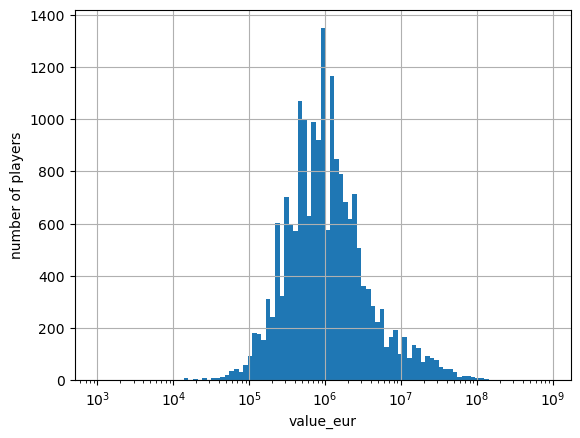

In [75]:
bins=10**(np.arange(3,9, 0.06))
plt.hist(df['value_eur'], bins)

plt.ylabel('number of players')
plt.xlabel('value_eur')
plt.xscale('log')
plt.grid()

plt.show()

Większość graczy wpada w przedział 100 tys. do 10 mln.

# Klasyfikacja

## Drzewa decyzyjne

### Pozycja

              precision    recall  f1-score   support

        Back       0.74      0.81      0.77      6520
     Forward       0.63      0.85      0.72      3388
  Goalkeeper       1.00      1.00      1.00      2124
      Middle       0.69      0.52      0.59      7133

    accuracy                           0.73     19165
   macro avg       0.76      0.79      0.77     19165
weighted avg       0.73      0.73      0.72     19165


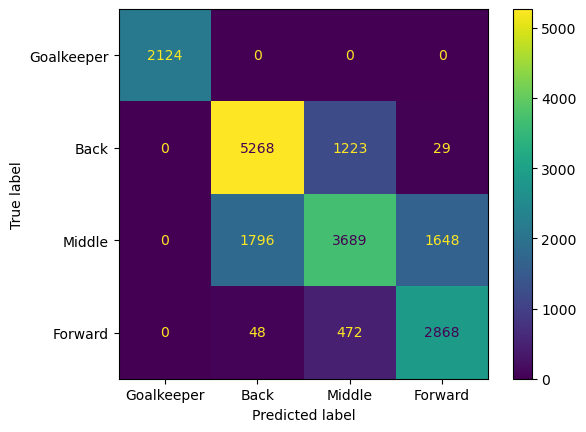

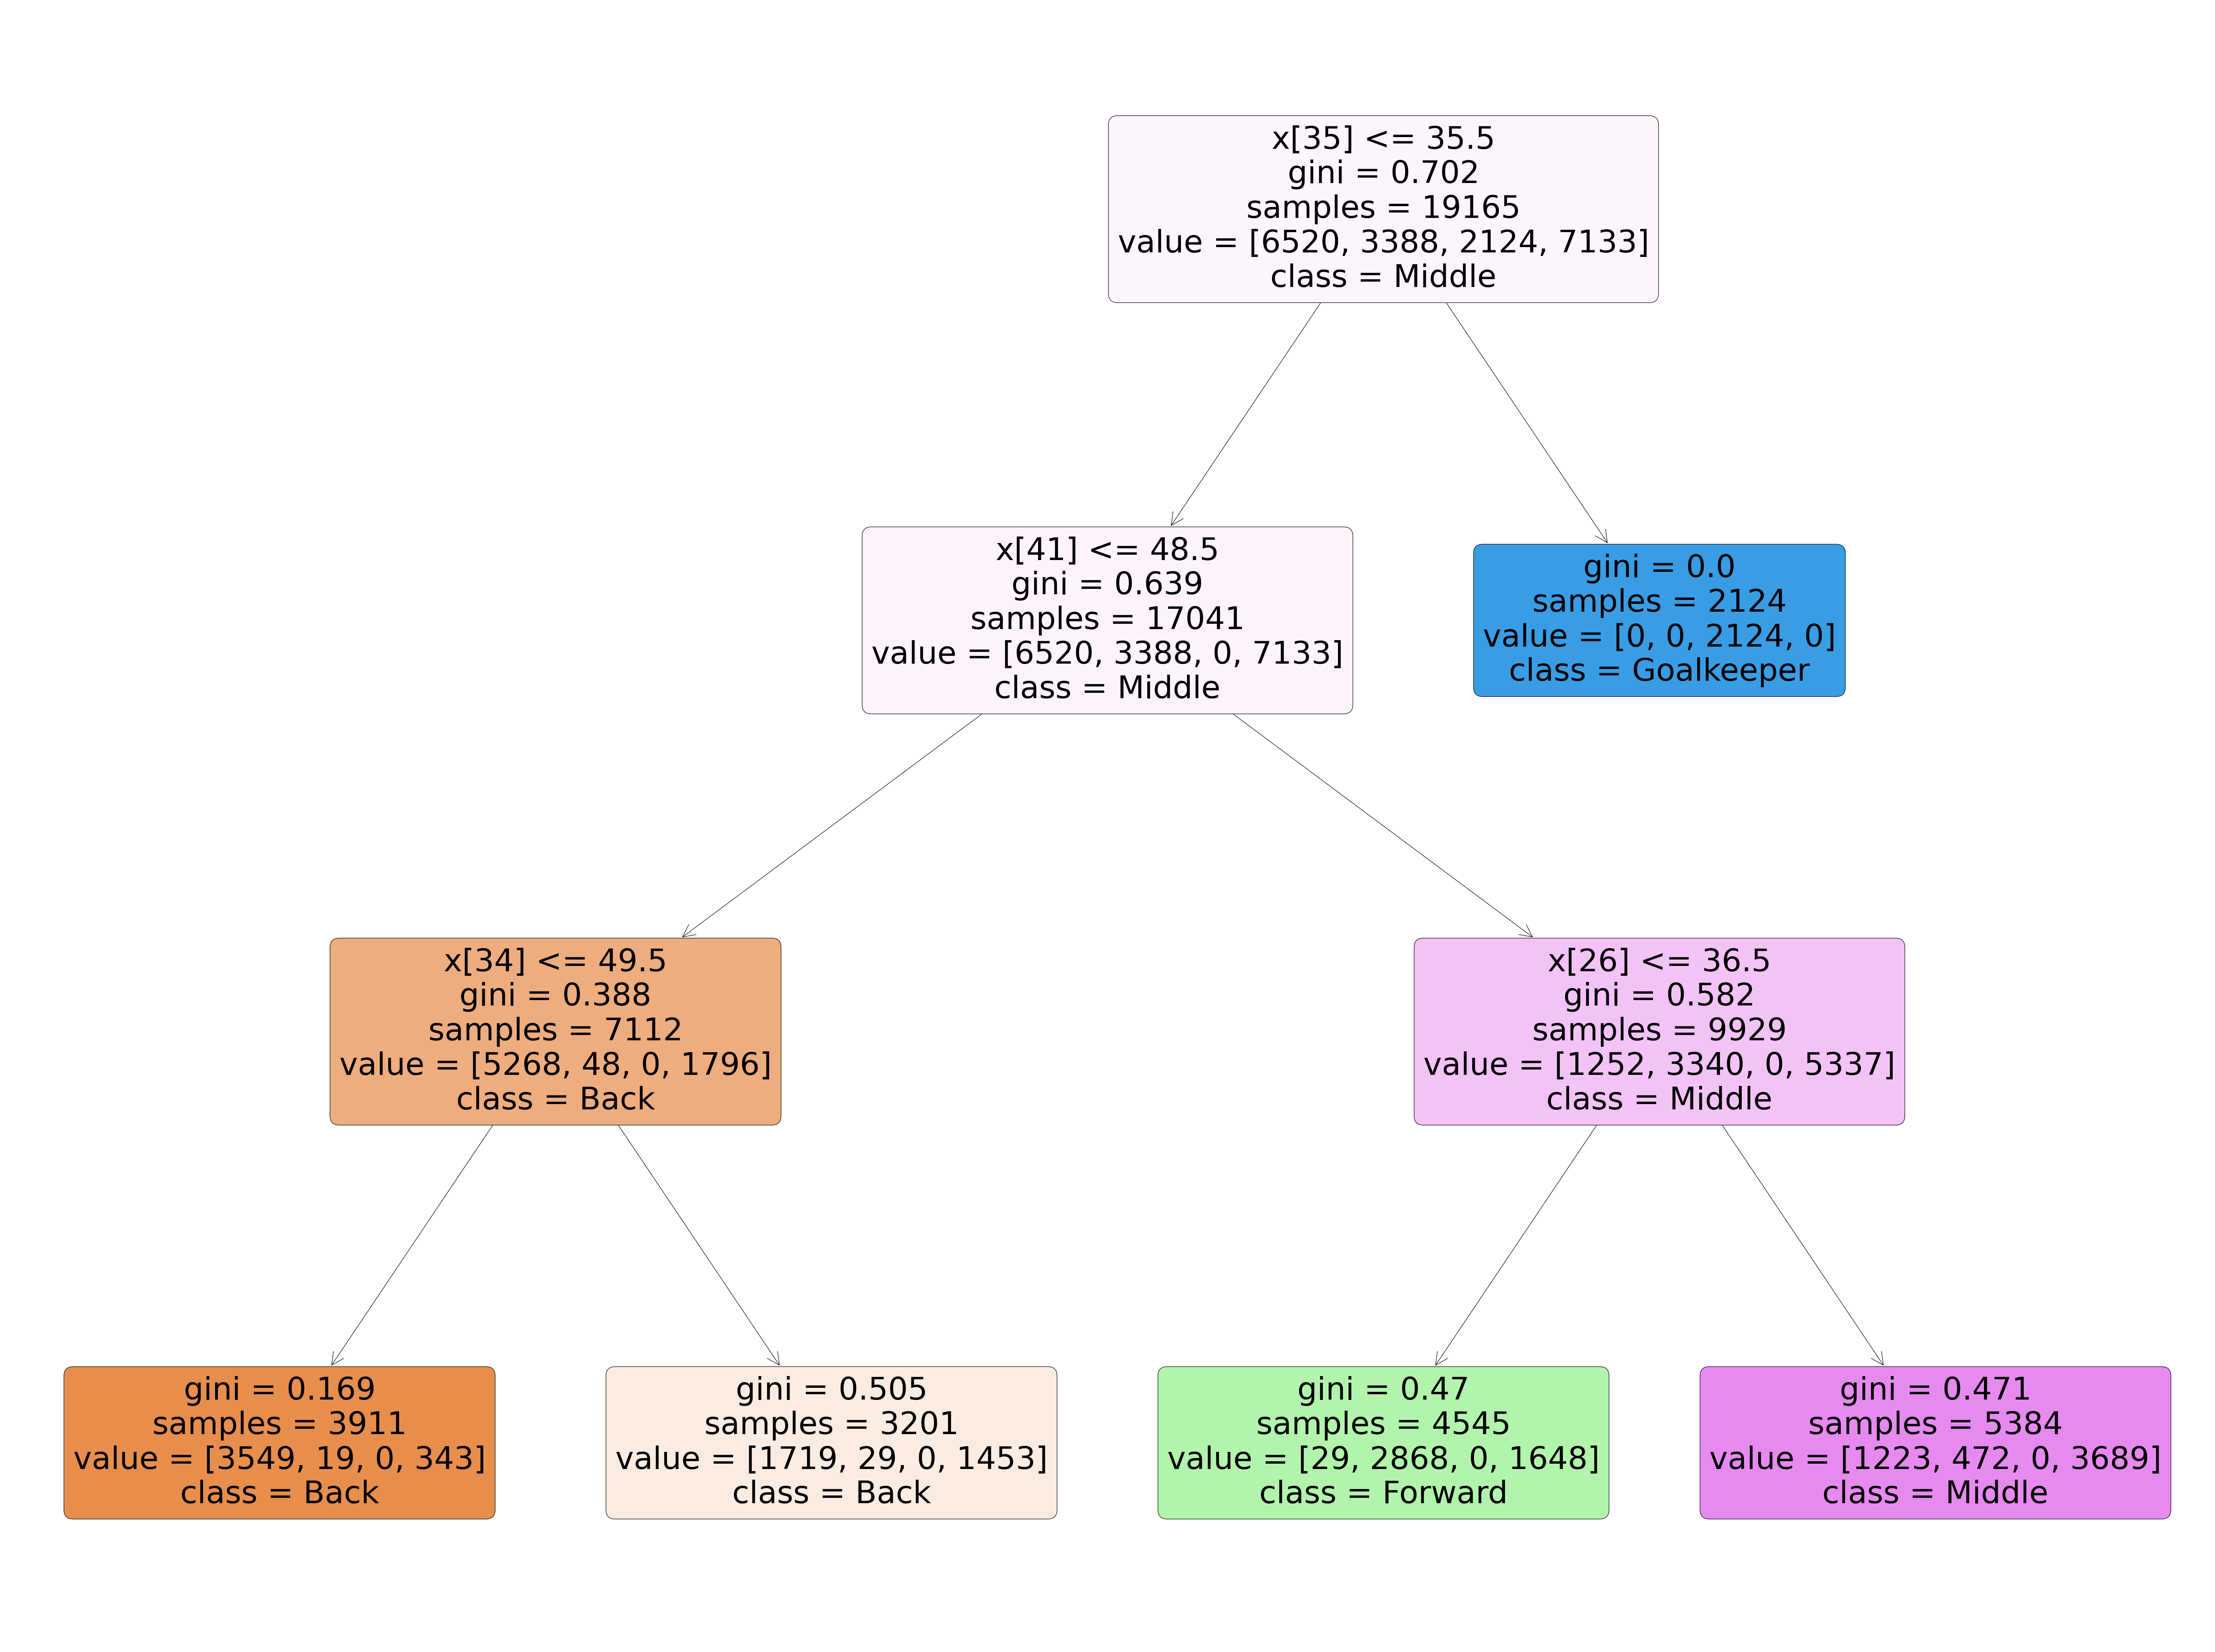

In [76]:
positions = np.array(['Goalkeeper', 'Back', 'Middle', 'Forward'])
features = list(set(cols_dict['all']) - set(cols_dict['descriptive']))
X_train = df[features]
y_train = df['player_position']

clf = DecisionTreeClassifier(
    random_state = 42,
    max_depth = 3,
    criterion = 'gini'
)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

cr = classification_report(
    y_train,
    y_pred,
    target_names=clf.classes_,
    zero_division=0
)
print(cr)

cm = confusion_matrix(
    y_train,
    y_pred,
    labels=positions
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=positions
)
disp.plot();

plt.figure(figsize=(80, 60))
plot_tree(
    clf,
    filled=True,
    rounded=True,
    label='all',
    class_names=list(clf.classes_)
);

Bramkarze zostają bez problemu odseparowani od reszty jeszcze w pierwszym rozgałęzieniu.

Obrońcy z napastnikami również są prawie idealnie rozróżniani.

Pomiędzy pozycjami obrońca-pomocnik oraz pomocnik-napastnik nie ma ścisłej granicy.

### Wartość piłkarza (top 10 'value_eur')

                    precision    recall  f1-score   support

   top10_value_eur       0.62      0.65      0.64      1794
bottom90_value_eur       0.96      0.96      0.96     17371

          accuracy                           0.93     19165
         macro avg       0.79      0.81      0.80     19165
      weighted avg       0.93      0.93      0.93     19165


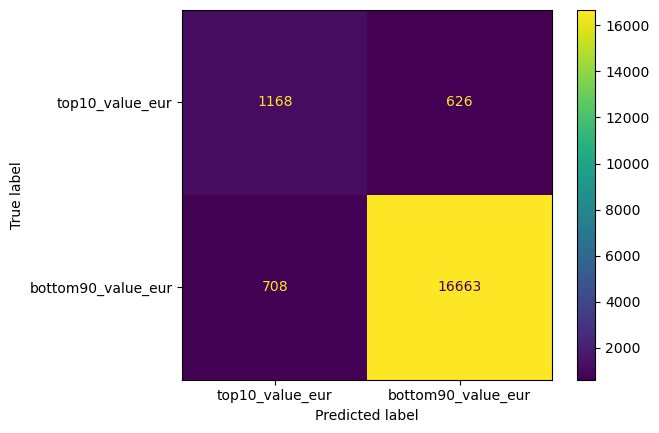

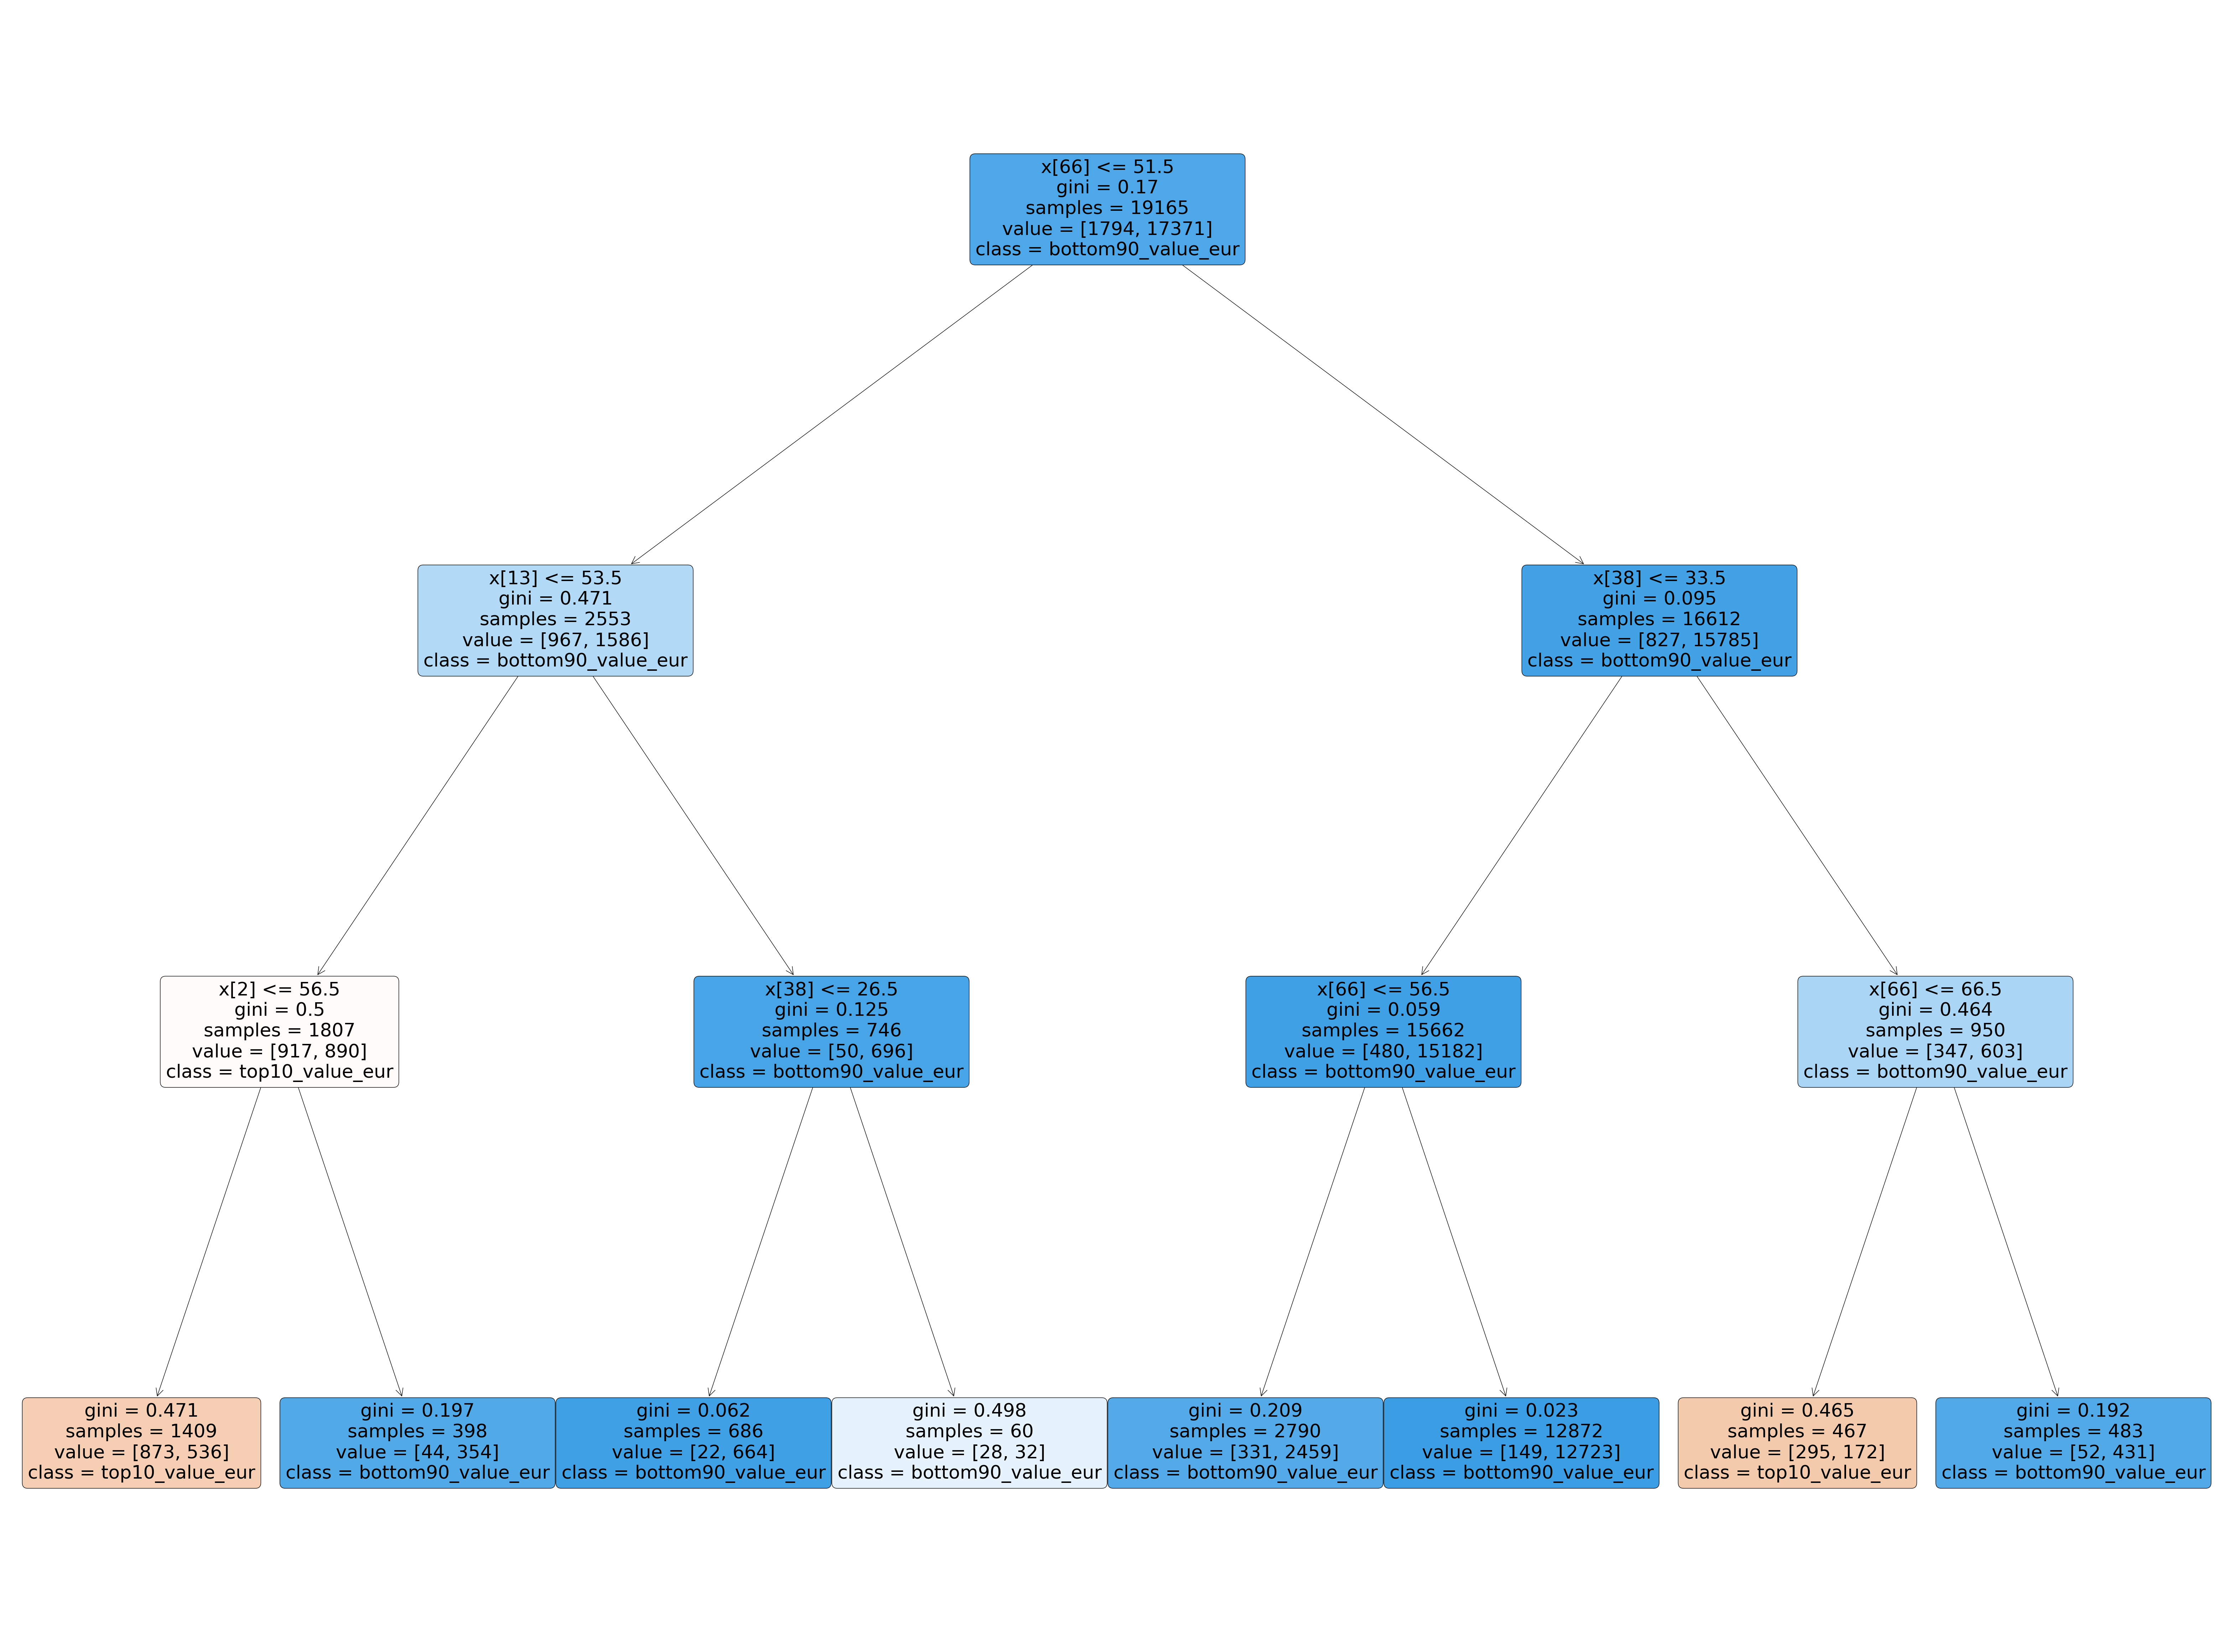

In [77]:
quantile10 = df['value_eur'].quantile(q=[0.1]).values[0]
df2 = df.copy()
df2['value_player'] = df.value_eur.apply(lambda x: 'top10_value_eur' if x >= quantile10 else 'bottom90_value_eur')
player_values = ['top10_value_eur', 'bottom90_value_eur']

features = list(set(cols_dict['all']) - set(cols_dict['descriptive']) - set(['value_eur']))
X_train = df[features]
y_train = df2['value_player']

clf = DecisionTreeClassifier(
    random_state = 42,
    max_depth = 3,
    criterion = 'gini'
)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

cr = classification_report(
    y_train,
    y_pred,
    target_names=player_values,
    zero_division=0
)
print(cr)

cm = confusion_matrix(
    y_train,
    y_pred,
    labels=clf.classes_
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=player_values
)
disp.plot();

plt.figure(figsize=(80, 60))
plot_tree(
    clf,
    filled=True,
    rounded=True,
    label='all',
    class_names=player_values
);

# Regresja

## Regresja liniowa

In [78]:
y = df['value_eur'].to_numpy()
y = y.reshape(y.size, 1)
features = list(set(cols_dict['all']) - set(cols_dict['descriptive']))
x = df[features]
x.drop(columns=['value_eur'])
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.575e+31
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        01:03:26   Log-Likelihood:             3.1476e+05
No. Observations:               19165   AIC:                        -6.294e+05
Df Residuals:                   19111   BIC:                        -6.290e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

array([[-1.26860601e+06, -1.26860601e+06],
       [ 1.86738601e+06,  1.86738601e+06],
       [-8.51918158e+05, -8.51918158e+05],
       [-3.18874639e+06, -3.18874639e+06],
       [-3.37249542e+06, -3.37249542e+06],
       [-3.18874639e+06, -3.18874639e+06],
       [-3.73663262e+06, -3.73663262e+06],
       [-8.33340806e+06, -8.33340806e+06],
       [-4.49434536e+06, -4.49434536e+06],
       [-3.53639350e+06, -3.53639350e+06],
       [-3.90843203e+06, -3.90843203e+06],
       [-3.90843203e+06, -3.90843203e+06],
       [-3.47407142e+06, -3.47407142e+06],
       [-3.47407142e+06, -3.47407142e+06],
       [-2.40205117e+06, -2.40205117e+06],
       [-1.20579570e+06, -1.20579570e+06],
       [-7.07202716e+05, -7.07202716e+05],
       [ 9.86815310e+05,  9.86815310e+05],
       [-2.07622789e+06, -2.07622789e+06],
       [-8.51918158e+05, -8.51918158e+05],
       [-8.92596023e+05, -8.92596023e+05],
       [-8.51918158e+05, -8.51918158e+05],
       [ 2.75280761e+06,  2.75280761e+06],
       [-1.

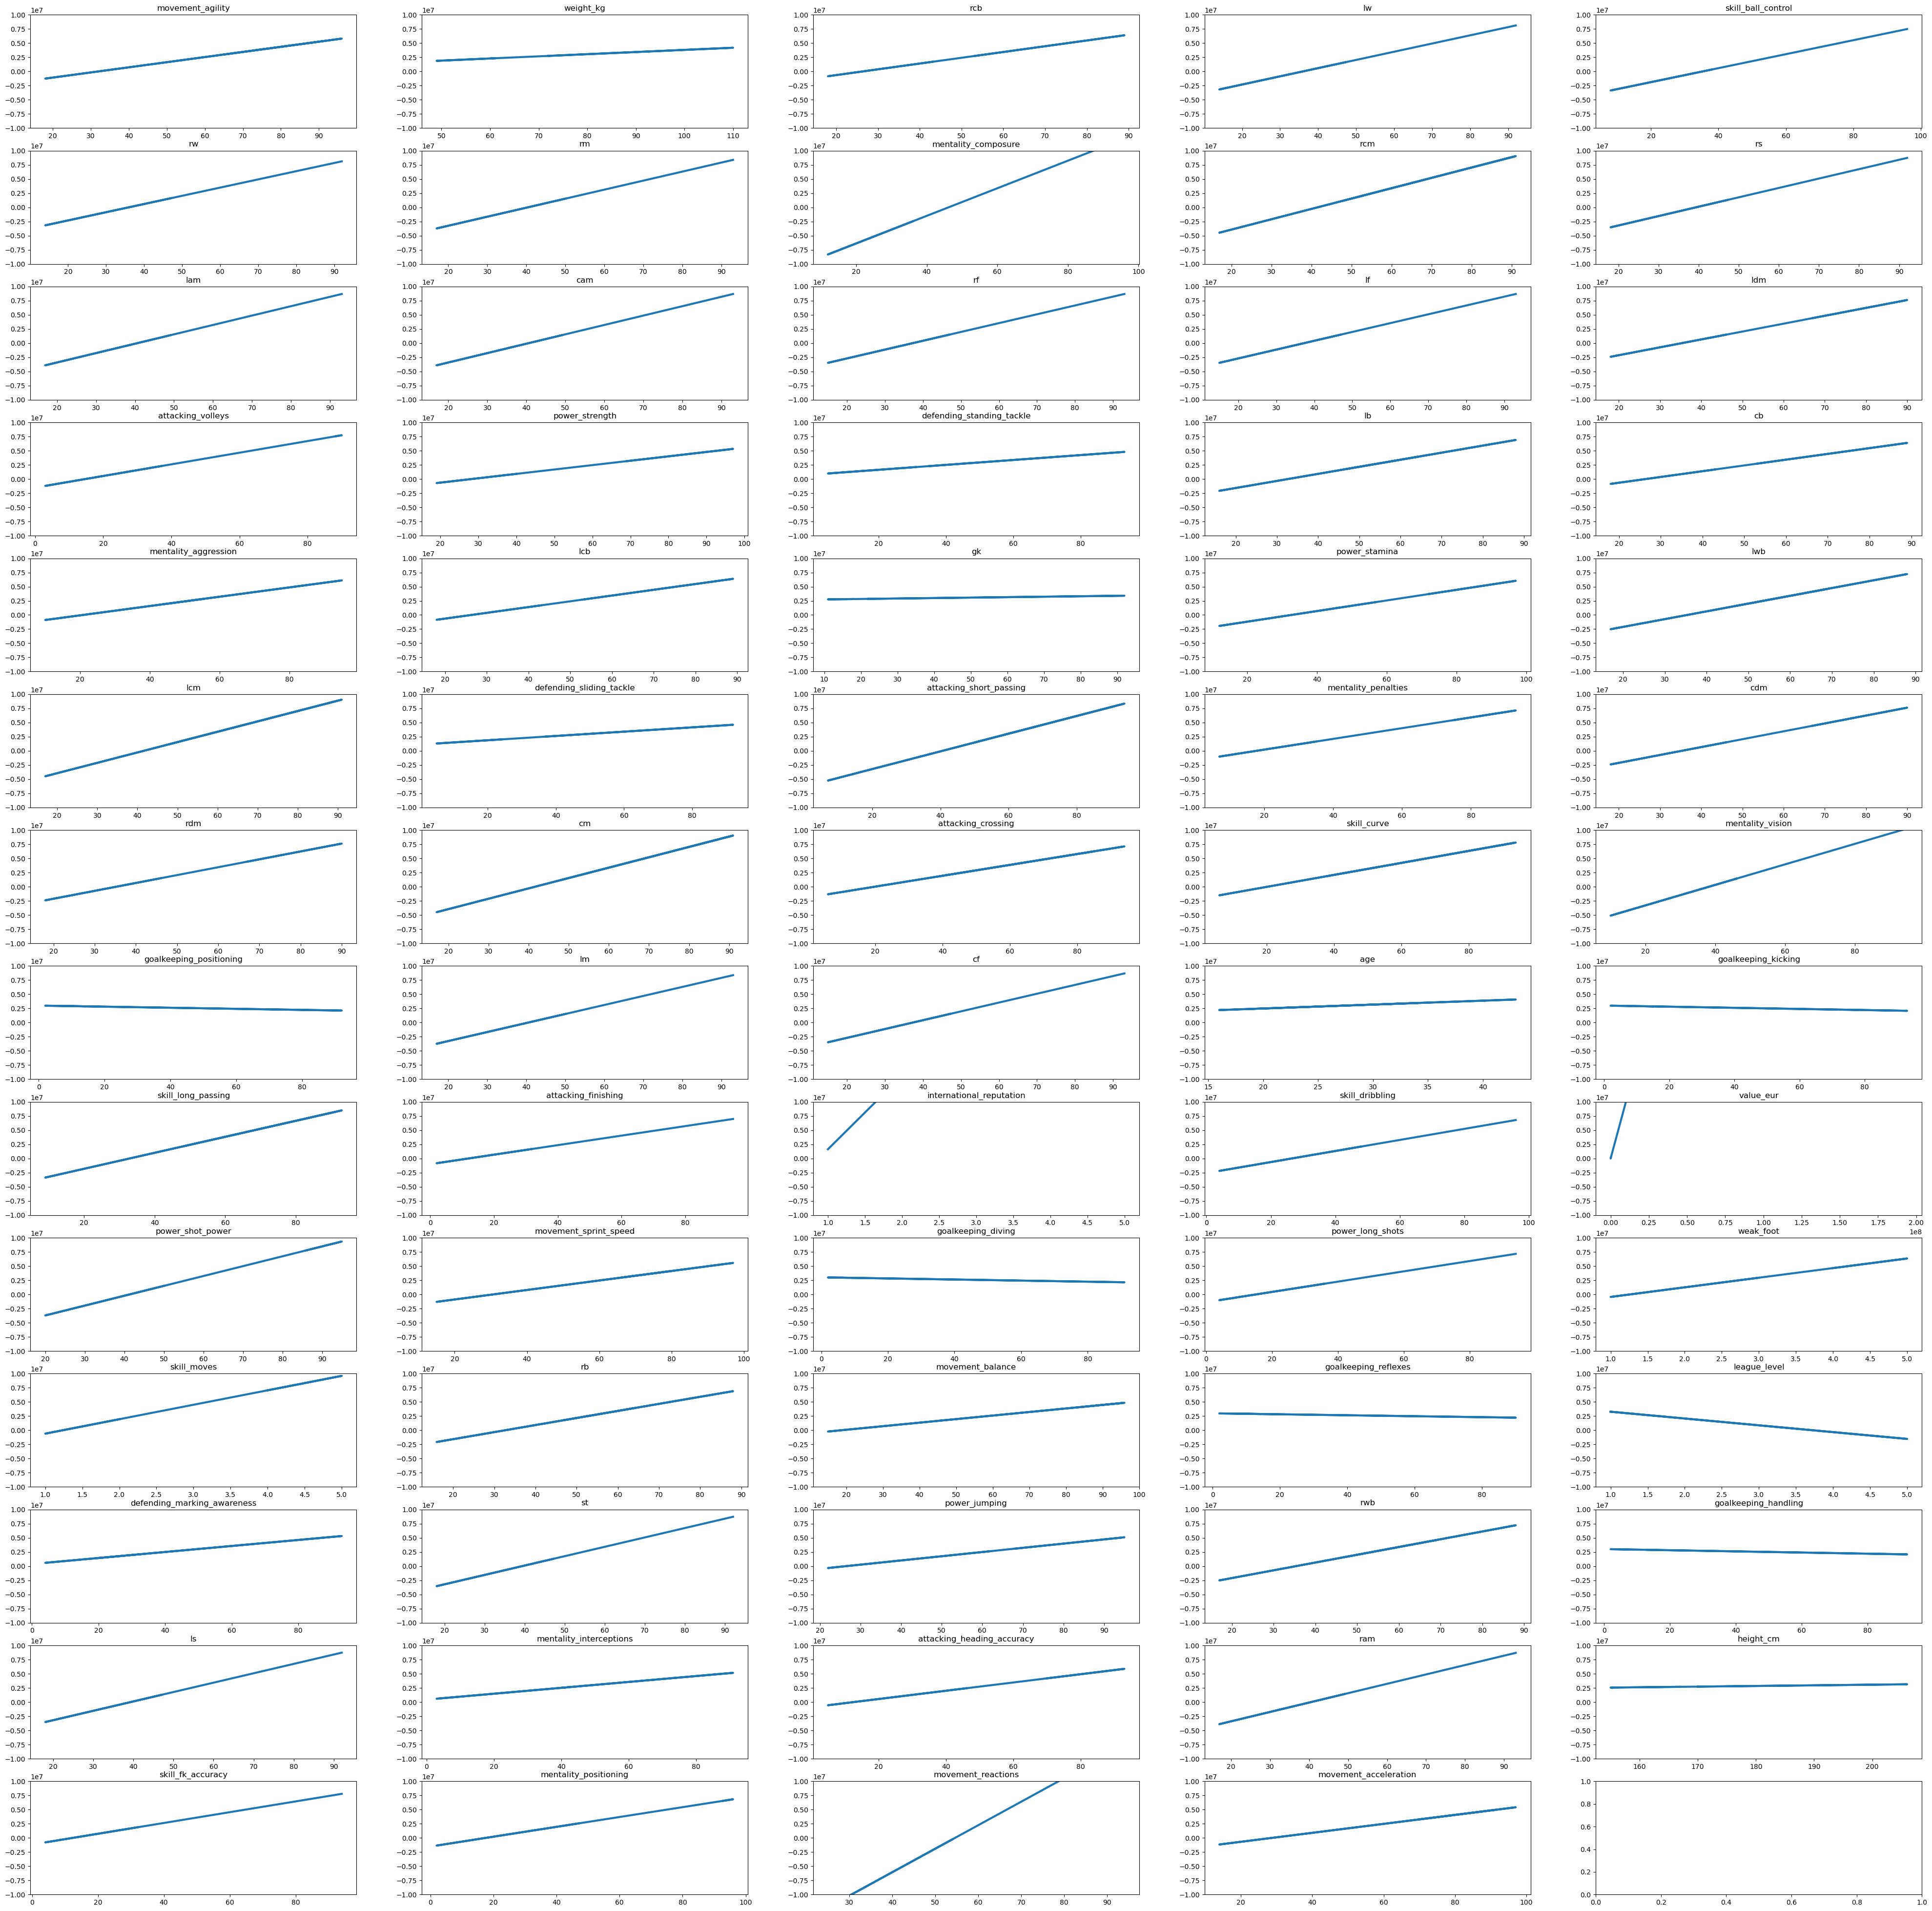

In [79]:
y = df['value_eur'].to_numpy()
y = y.reshape(y.size, 1)
features = list(set(cols_dict['all']) - set(cols_dict['descriptive']))
x = df[features]
regr = linear_model.LinearRegression()
iter_1 = 0
iter_2 = 0
iter_3 = 0
num_of_plots = len(x.columns)
num_of_rows = math.ceil(num_of_plots/5)
min_max_values = np.ndarray((num_of_plots, 2))
figure, axis = plt.subplots(num_of_rows, 5, figsize=(50, 50))
for column in x:
    x_ = x[column].values
    x_ = x_.reshape(x_.size, 1)
    regr.fit(x_,y)
    axis[iter_1, iter_2].plot(x_, regr.predict(x_), linewidth=3) 
    axis[iter_1, iter_2].set_title(column)
    axis[iter_1, iter_2].set_ylim(-10**7, 10**7)

    min_max_values[iter_3, 0] = min(regr.predict(x_))
    min_max_values[iter_3, 1] = min(regr.predict(x_))

    iter_3 = iter_3 + 1
    iter_2 = iter_2 + 1
    if iter_2 > 4:
        iter_1 = iter_1 + 1
        iter_2 = 0
        
min_max_values